__keras in concrete dataset__

__ZHOU DUO, G2103160J__

__SPMS, NTU__

Hi, Prof. Li, I sincerely recommend that you use Rstudio to run the code

# The purpose of Assignment 2

## Trace back to Assignment 1
* The assignment 1 is about regression problem, we aim to predict the output of a continuous value， where aim to predict a discrete label. So, using keras to regrese the concrete dataset might be get a better performance than neuralnet. 

## Tidy-r
* In addition, keras is depend on tidy-r, which terms of syntax is like python, but more beautiful.


* The learning cost of a research tool depends to a large extent on the readability and consistency of the API. The characteristic of base-r is that there are many packages but the API is chaotic and inconsistent, because the functions of each package cannot be partially comprehensive. 


* The emergence of tidyverse brought R, who was overtaken by Python, back to life. The main function packages are centralized, the API is not only unified, but also surpasses Python in terms of syntax beauty. In particular, the integration of graphical grammar and SQL pipeline flow has made it a benchmark in the industry.

## Therefore, the purpose of this article is:

1. Explore the regression analysis of keras;

2. Feel the beauty of tidy-r's syntax.

# Regression by keras

## Load data & set train/test

In [4]:
requiredPackages <- c('keras','dplyr','ggplot2','tfdatasets')
if (length(setdiff(requiredPackages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(requiredPackages, rownames(installed.packages())))  
}
library(keras)
library(dplyr)
library(ggplot2)
library(tfdatasets)

In [5]:
# read dataset & set train & test
concrete <- read.csv("Concrete.csv")
concrete_train <- concrete[1:773, ]
concrete_test <- concrete[774:1030, ]

train_data <- concrete_train[,-9]
train_labels <- concrete_train[,9]
test_data <- concrete_test[,-9]
test_labels <- concrete_test[,9]

paste0("Training entries: ", length(train_data), ", labels: ", length(train_labels))
train_data[1, ]

[1] "Training entries: 8, labels: 773"

cement,slag,ash,water,superplastic,coarseagg,fineagg,age
540,0,0,162,2.5,1040,676,28


## Normalize features

It’s recommended to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model more dependent on the choice of units used in the input.

We are going to use the feature_spec interface implemented in the tfdatasets package for normalization. The feature_columns interface allows for other common pre-processing operations on tabular data.

In [6]:
# normalization
train_df <- train_data %>% 
  as_tibble(.name_repair = "minimal") %>% 
  mutate(label = train_labels)

test_df <- test_data %>% 
  as_tibble(.name_repair = "minimal") %>% 
  mutate(label = test_labels)
spec <- tfdatasets::feature_spec(train_df, label ~ . ) %>% 
  tfdatasets::step_numeric_column(all_numeric(), normalizer_fn = scaler_standard()) %>% 
  fit()
spec

-- Feature Spec ---------------------------------------------------------------- 
A feature_spec with 8 steps.
Fitted: TRUE 
-- Steps ----------------------------------------------------------------------- 
The feature_spec has 1 dense features.
StepNumericColumn: cement, slag, ash, water, superplastic, coarseagg, fineagg, age 
-- Dense features -------------------------------------------------------------- 

The spec created with tfdatasets can be used together with layer_dense_features to perform pre-processing directly in the TensorFlow graph.

We can take a look at the output of a dense-features layer created by this spec:

In [7]:
layer <- layer_dense_features(
  feature_columns = dense_features(spec), 
  dtype = tf$float32
)
layer(train_df)

ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: ('We expected a dictionary here. Instead we got: ',      cement   slag  ash  water  superplastic  coarseagg  fineagg  age  label
0     540.0    0.0  0.0  162.0           2.5     1040.0    676.0   28  79.99
1     540.0    0.0  0.0  162.0           2.5     1055.0    676.0   28  61.89
2     332.5  142.5  0.0  228.0           0.0      932.0    594.0  270  40.27
3     332.5  142.5  0.0  228.0           0.0      932.0    594.0  365  41.05
4     198.6  132.4  0.0  192.0           0.0      978.4    825.5  360  44.30
..      ...    ...  ...    ...           ...        ...      ...  ...    ...
768   331.0    0.0  0.0  192.0           0.0      978.0    825.0  180  39.00
769   331.0    0.0  0.0  192.0           0.0      978.0    825.0  360  41.24
770   349.0    0.0  0.0  192.0           0.0     1047.0    806.0    3  14.99
771   331.0    0.0  0.0  192.0           0.0      978.0    825.0    3  13.52
772   382.0    0.0  0.0  186.0           0.0     1047.0    739.0    7  24.00

[773 rows x 9 columns])

Detailed traceback:
  File "C:\Users\Clause\AppData\Local\R-MINI~1\envs\R-RETI~1\lib\site-packages\keras\engine\base_layer.py", line 1037, in __call__
    outputs = call_fn(inputs, *args, **kwargs)
  File "C:\Users\Clause\AppData\Local\R-MINI~1\envs\R-RETI~1\lib\site-packages\keras\feature_column\dense_features.py", line 159, in call
    features)



## Create the model

Let’s build our model. Here we will use the Keras functional API - which is the recommended way when using the feature_spec API. Note that we only need to pass the dense_features from the spec we just created. Then, we cpmpute the model

In [8]:
# model
input <- layer_input_from_dataset(train_df %>% select(-label))
output <- input %>% 
  layer_dense_features(dense_features(spec)) %>% 
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 64, activation = "relu") %>%
  layer_dense(units = 1) 
model <- keras_model(input, output)
summary(model)

Model: "model"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
age (InputLayer)          [(None,)]         0                                   
________________________________________________________________________________
ash (InputLayer)          [(None,)]         0                                   
________________________________________________________________________________
cement (InputLayer)       [(None,)]         0                                   
________________________________________________________________________________
coarseagg (InputLayer)    [(None,)]         0                                   
________________________________________________________________________________
fineagg (InputLayer)      [(None,)]         0                                   
________________________________________________________________________________
slag (InputLa

In [9]:
# compute
model %>% 
  compile(
    loss = "mse",
    optimizer = optimizer_rmsprop(),
    metrics = list("mean_absolute_error")
  )

## Train the model

The model is trained for 500 epochs, recording training and validation accuracy in a keras_training_history object. We also show how to use a custom callback, replacing the default training output by a single dot per epoch.

In [10]:
# Display training progress by printing a single dot for each completed epoch.
print_dot_callback <- callback_lambda(
  on_epoch_end = function(epoch, logs) {
    if (epoch %% 80 == 0) cat("\n")
    cat(".")
  }
)    

history <- model %>% fit(
  x = train_df %>% select(-label),
  y = train_df$label,
  epochs = 500,
  validation_split = 0.2,
  verbose = 0,
  callbacks = list(print_dot_callback)
)


................................................................................
................................................................................
................................................................................
................................................................................
................................................................................
................................................................................
....................

show the tarin process

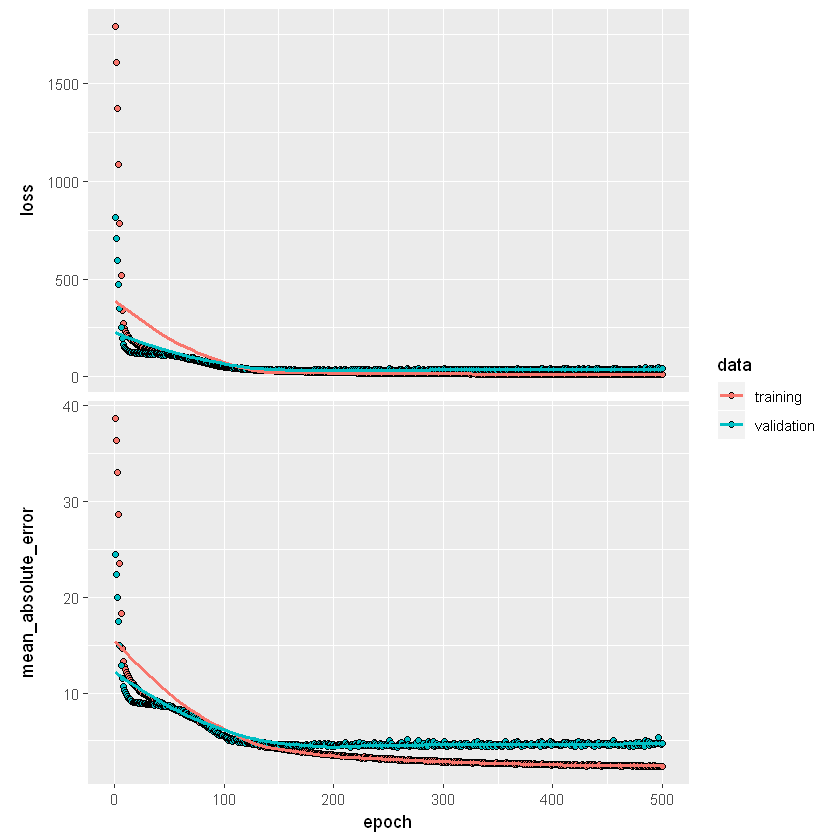

In [11]:
plot(history)

## Prediction 

In [12]:
scores <- model %>% 
  evaluate(test_df, test_df$label, verbose = 0)
scores

loss mean_absolute_error 
          128.79021             8.61625

## Conclusion

1. This assignment introduced a few techniques to handle a regression problem and the beauty of syntex in tidy-r.
2. Mean Squared Error (MSE) is a common loss function used for regression problems (different than classification problems).
3. Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
4. When input data features have values with different ranges, each feature should be scaled independently.
5. If there is not much training data, prefer a small network with few hidden layers to avoid overfitting.